In [1]:
#Import of preprocessedText Data
import pandas as pd

df = pd.read_csv("PreprocessedText.csv")
df.head()

,doc_id,country,year,strategy_name,file_name,text
0,CAN_2022,CAN,2022,Canada's National Quantum Strategy,CAN_2022_Canada's National Quantum Strategy.pdf,io executive summary advance quantum science p...
1,GER_2023,GER,2023,Quantum Technologies Conceptual Framework Prog...,GER_2023_Quantum Technologies Conceptual Frame...,1 exploit potential quantum technology germany...
2,UK_2023,UK,2023,National Quantum Strategy,UK_2023_National Quantum Strategy.pdf,ministerial foreword first generation quantum ...
3,USA_2018,USA,2018,NATIONAL STRATEGIC OVERVIEW FOR QUANTUM INFO...,USA_2018_NATIONAL STRATEGIC OVERVIEW FOR QUAN...,lsn report 2017 operationalizing software defi...


In [2]:
# Creation of Dictionary and Corpus 
QH_DICT = {
    "government": [
        "government", "state", "public sector", "ministry", "agency",
        "regulation", "policy", "legislation", "governance",
        "public funding", "subsidy", "public procurement"
    ],
    "society": [
        "society", "civil society", "citizen", "public", "community",
        "ngo", "non profit", "foundation", "participation",
        "public engagement", "social impact", "trust"
    ],
    "industry": [
        "industry", "business", "private sector", "company", "firm",
        "enterprise", "startup", "sme", "corporation",
        "commercialization", "market", "value chain"
    ],
    "academia": [
        "academia", "academic", "university", "higher education",
        "research institution", "research", "scientific",
        "laboratory", "technology transfer"
    ]
}

<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:16: SyntaxWarning: invalid escape sequence '\s'
C:\Users\user\AppData\Local\Temp\ipykernel_20668\2820073871.py:16: SyntaxWarning: invalid escape sequence '\s'
  """


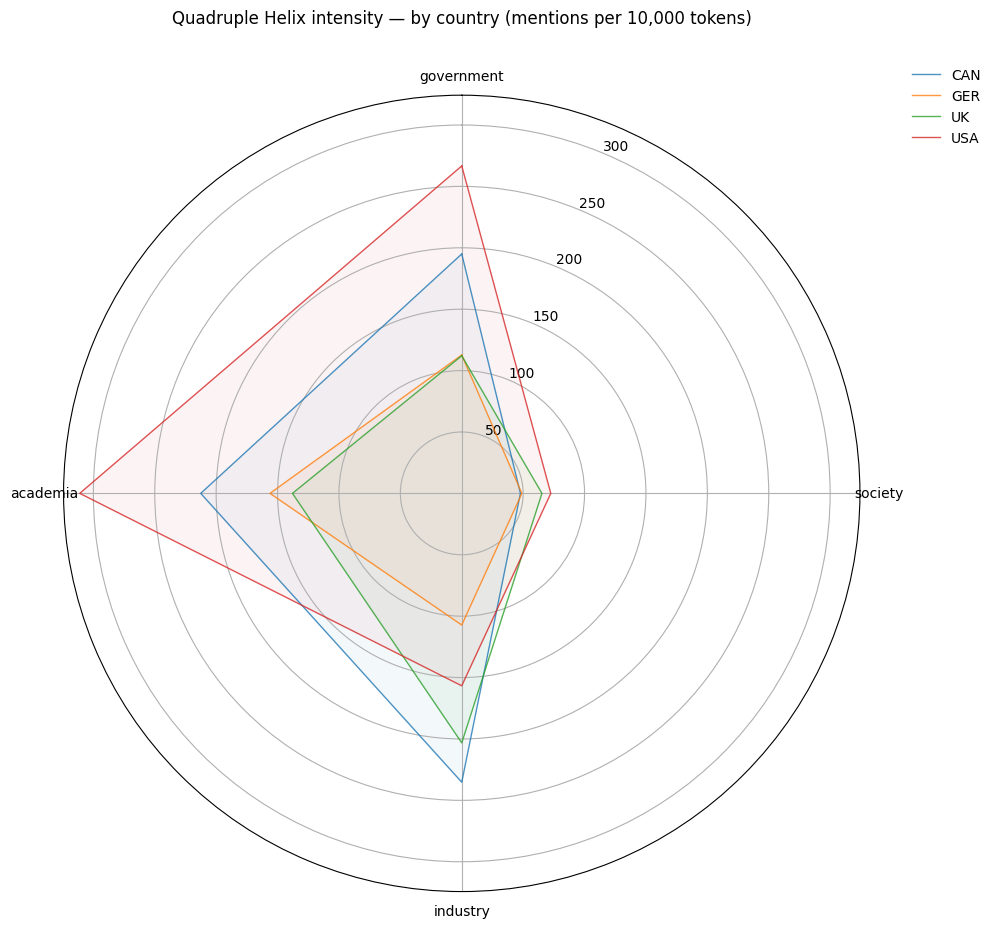

In [3]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from math import pi

# -------------------------
# 1) Robust counting helpers (handles multi-word phrases)
# -------------------------
_token_re = re.compile(r"[a-z0-9]+(?:'[a-z0-9]+)?", re.IGNORECASE)

def n_tokens(text: str) -> int:
    return len(_token_re.findall(text))

def build_phrase_pattern(phrase: str) -> re.Pattern:
    """
    Match phrase as whole words; multiword phrases allow any whitespace.
    Example: "public sector" -> r"\bpublic\s+sector\b"
    """
    parts = [re.escape(p) for p in phrase.lower().strip().split()]
    pat = r"\b" + r"\s+".join(parts) + r"\b"
    return re.compile(pat, flags=re.IGNORECASE)

# Precompile patterns
compiled = {
    area: [build_phrase_pattern(term) for term in terms]
    for area, terms in QH_DICT.items()
}

def count_area_regex(text: str, patterns: list[re.Pattern]) -> int:
    return sum(len(p.findall(text)) for p in patterns)

# -------------------------
# 2) Create QH counts + (optional) normalize
# -------------------------
# Country column assumption (adjust if your column name differs)
# df needs a 'country' column in PreprocessedText.csv
if "country" not in df.columns:
    raise ValueError("Your CSV needs a 'country' column. If it's named differently, rename it first.")

df["n_tokens"] = df["text"].apply(n_tokens)

for area, patterns in compiled.items():
    df[area] = df["text"].apply(lambda t: count_area_regex(t, patterns))

qh_cols = list(QH_DICT.keys())

# Aggregate per country (sum over all documents)
country_sum = (
    df.groupby("country", as_index=True)[qh_cols + ["n_tokens"]]
      .sum()
)

# Choose ONE normalization:
# A) absolute counts (raw)
country_profile_abs = country_sum[qh_cols].copy()

# B) relative intensity per 10,000 tokens (recommended for comparability)
country_profile_per10k = (country_sum[qh_cols].div(country_sum["n_tokens"], axis=0) * 10000).replace([np.inf, -np.inf], np.nan).fillna(0)

# C) within-country shares of QH mentions (sums to 1 across the 4 axes)
country_profile_share = country_sum[qh_cols].div(country_sum[qh_cols].sum(axis=1).replace(0, np.nan), axis=0).fillna(0)

# Pick what you want to plot:
PROFILE = country_profile_per10k   # <-- change to country_profile_abs or country_profile_share

# -------------------------
# 3) Radar chart (all countries on one spider chart + legend)
# -------------------------
labels = qh_cols
N = len(labels)
angles = np.linspace(0, 2*pi, N, endpoint=False).tolist()
angles += angles[:1]  # close loop

fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(111, polar=True)

# Make it look like a radar
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)

# Plot each country
for country, row in PROFILE.iterrows():
    values = row.values.astype(float).tolist()
    values += values[:1]  # close loop
    ax.plot(angles, values, linewidth=1, alpha=0.8, label=str(country))
    ax.fill(angles, values, alpha=0.05)

# Title based on profile choice
if PROFILE is country_profile_abs:
    title = "Quadruple Helix mentions — by country (absolute counts)"
elif PROFILE is country_profile_share:
    title = "Quadruple Helix composition — by country (share within QH mentions)"
else:
    title = "Quadruple Helix intensity — by country (mentions per 10,000 tokens)"

ax.set_title(title, y=1.08)

# Legend: put outside (important when many countries)
ax.legend(loc="upper left", bbox_to_anchor=(1.05, 1.05), frameon=False)

plt.tight_layout()
plt.show()

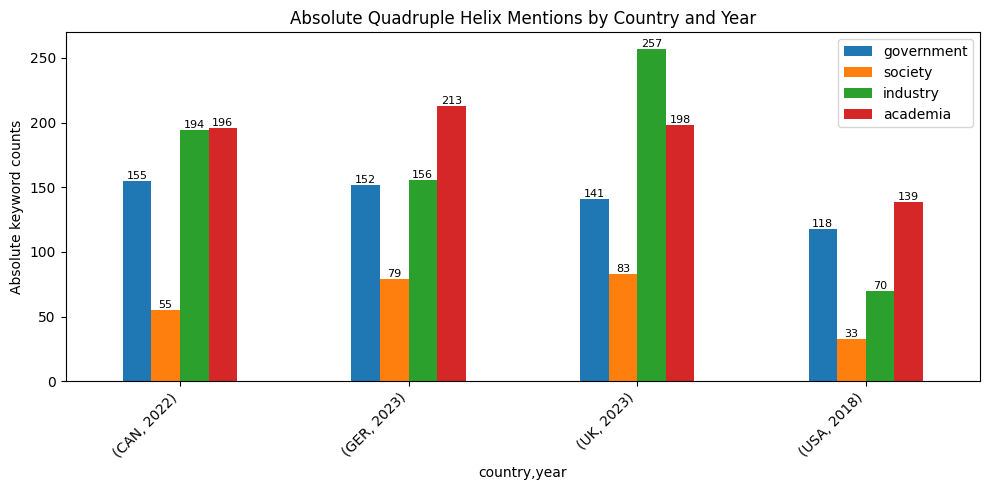

In [4]:
# Absolute QH counts per document
import matplotlib.pyplot as plt

# Function to count keywords in text
def count_area(text, keywords):
    text = str(text).lower()
    return sum(text.count(k) for k in keywords)

# create QH columns per document
for area, keywords in QH_DICT.items():
    df[area] = df["text"].apply(lambda x: count_area(x, keywords))

# Aggregate counts by country and year
qh_cols = list(QH_DICT.keys())

agg_df = (
    df
    .groupby(["country", "year"], as_index=False)[qh_cols]
    .sum()
)


#agg_df.sort_values(["country", "year"]).head()

ax = agg_df.set_index(["country", "year"])[qh_cols].plot(
    kind="bar",
    figsize=(10, 5)
)

plt.ylabel("Absolute keyword counts")
plt.title("Absolute Quadruple Helix Mentions by Country and Year")
plt.xticks(rotation=45, ha="right")

# add labels
for container in ax.containers:
    ax.bar_label(container, fmt="%.0f", fontsize=8)

plt.tight_layout()
plt.show()



(array([0, 1, 2, 3]),
 [Text(0, 0, '(CAN, 2022)'),
  Text(1, 0, '(GER, 2023)'),
  Text(2, 0, '(UK, 2023)'),
  Text(3, 0, '(USA, 2018)')])

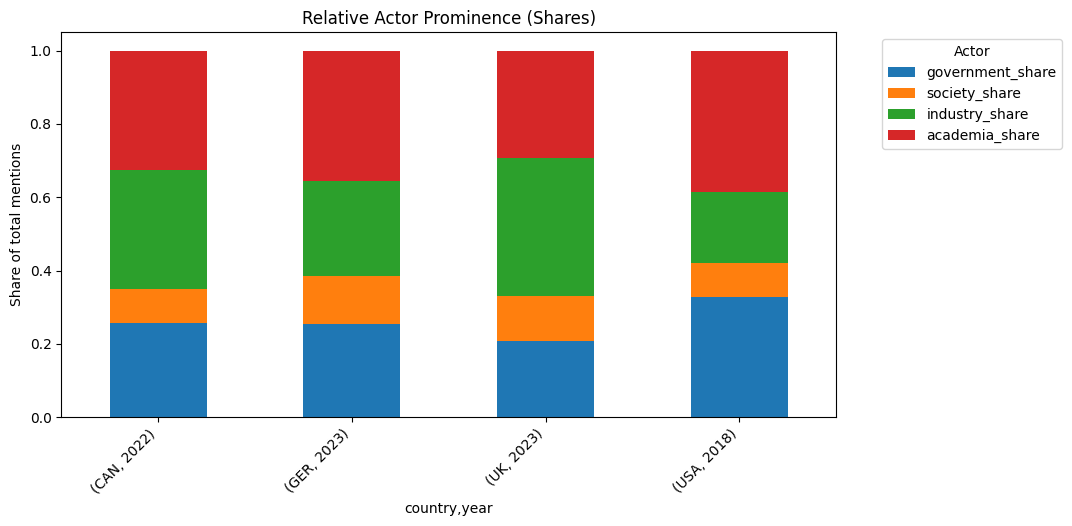

In [5]:
#Relative shares (within each country–year) - How dominant is each helix actor relative to the others?

rel_df = agg_df.copy()

row_sum = rel_df[qh_cols].sum(axis=1)

for col in qh_cols:
    rel_df[f"{col}_share"] = rel_df[col] / row_sum

#rel_df.sort_values(["country", "year"]).head()

share_cols = [f"{c}_share" for c in qh_cols]

rel_df.set_index(["country", "year"])[share_cols].plot(
    kind="bar",
    stacked=True,
    figsize=(10, 5)
)

plt.ylabel("Share of total mentions")
plt.title("Relative Actor Prominence (Shares)")
plt.legend(title="Actor", bbox_to_anchor=(1.05, 1))
plt.xticks(rotation=45, ha="right")



In [6]:
# Actor dominance indicator (winner-takes-most)

dom_df = agg_df.copy()

dom_df["dominant_actor"] = dom_df[qh_cols].idxmax(axis=1)
dom_df["dominance_share"] = (
    rel_df[[f"{c}_share" for c in qh_cols]].max(axis=1)
)

dom_df[["country", "year", "dominant_actor", "dominance_share"]].head()



,country,year,dominant_actor,dominance_share
0,CAN,2022,academia,0.326667
1,GER,2023,academia,0.355000
2,UK,2023,industry,0.378498
3,USA,2018,academia,0.386111


In [7]:
# total words per country-year
wc_df = (
    df
    .groupby(["country", "year"], as_index=False)["text"]
    .apply(lambda x: x.str.split().str.len().sum())
    .rename(columns={"text": "word_count"})
)

norm_df = agg_df.merge(wc_df, on=["country", "year"])

for col in qh_cols:
    norm_df[f"{col}_per_1k_words"] = norm_df[col] / norm_df["word_count"] * 1000

norm_df[[ "country", "year"] + [f"{c}_per_1k_words" for c in qh_cols]].head()

,country,year,government_per_1k_words,society_per_1k_words,industry_per_1k_words,academia_per_1k_words
0,CAN,2022,19.984528,7.091284,25.012893,25.270758
1,GER,2023,12.122179,6.300343,12.441184,16.987001
2,UK,2023,11.568756,6.809977,21.086314,16.245487
3,USA,2018,28.372205,7.934600,16.830969,33.421496


In [19]:
#Is the narrative balanced or dominated by one actor? High balance → participatory narrative; Low balance → dominated by one helix

balance_df = rel_df.copy()

balance_df["qh_concentration"] = (
    balance_df[[f"{c}_share" for c in qh_cols]] ** 2
).sum(axis=1)

balance_df["qh_balance"] = 1 - balance_df["qh_concentration"]

balance_df[["country", "year", "qh_balance"]].head()

,country,year,qh_balance
0,CAN,2022,0.713353
1,GER,2023,0.724269
2,UK,2023,0.713605
3,USA,2018,0.696803


In [20]:
# Inequality of QH shares per country-year

ineq_df = rel_df.copy()

ineq_df["qh_range"] = (
    ineq_df[[f"{c}_share" for c in qh_cols]].max(axis=1)
    - ineq_df[[f"{c}_share" for c in qh_cols]].min(axis=1)
)

ineq_df[["country", "year", "qh_range"]].head()

,country,year,qh_range
0,CAN,2022,0.234219
1,GER,2023,0.226131
2,UK,2023,0.255507
3,USA,2018,0.296399


In [21]:
print("hallo")

hallo


In [22]:
# Individual Keyword Analysis